<a href="https://colab.research.google.com/github/goldenfries100/171Group14/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install scikeras
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import torch
import torchvision
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scikeras.wrappers import KerasClassifier
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import save_model, load_model
import cv2
from mlxtend.evaluate import scoring
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [3]:

try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
    ! git clone https://github.com/goldenfries100/171Group14 data
except:
    IN_COLAB = False

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

if IN_COLAB:
    head = r'/content/data/'
else:
    head = r'./'
file = head + r'cifar-10-batches-py/batches.meta'
batches_meta_file = unpickle(file)
print(batches_meta_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'data' already exists and is not an empty directory.
{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


### EDA(Exploratory Data Analysis)

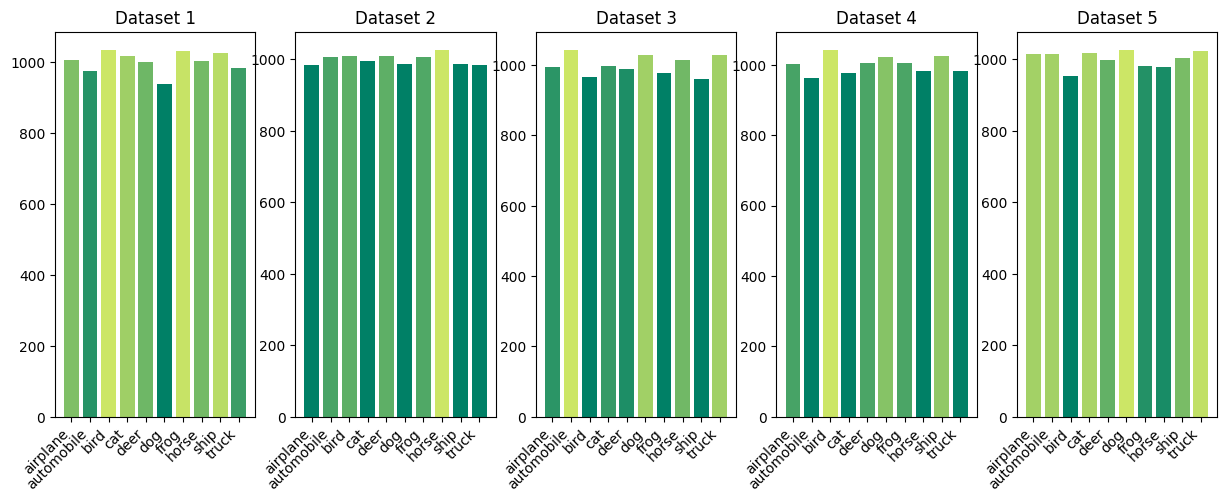

--- The total number of each class in the entire dataset is equal ---


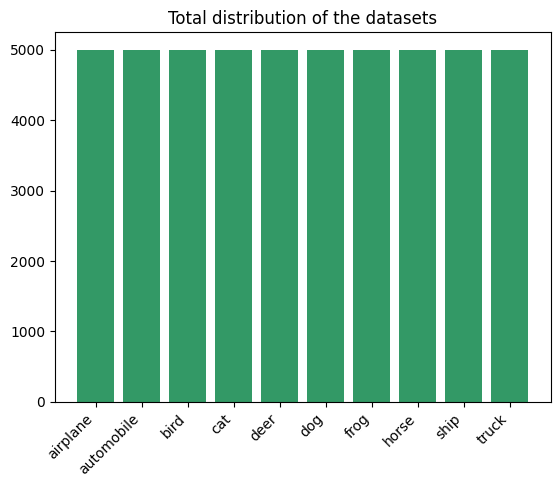

In [4]:
NUM_DATASETS = 5
num_cases_per_batch = batches_meta_file['num_cases_per_batch']
label_names = batches_meta_file['label_names']
# random shuffling of data indices
random_image_indexes = (random.sample(range(num_cases_per_batch), num_cases_per_batch))
# complete dataset array
dataset_array = []
# the primary data in the dataset, contains a 50000 length array of 32x32x3 0-255 RGB values
images = []
# class labels for each image, a 50000 array of ints 0-9 corresponding to indices into label_names
labels = []
# iterate over each dataset
for i in range(NUM_DATASETS):
  # read i-th dataset from file
  dataset_array.append(unpickle(head + f'cifar-10-batches-py/data_batch_{i+1}'))
  # reshape the images into readable RGB pixel format
  dataset_array[i]['data']
  # shuffle the images according to the random image indexes generated above
  images.append(dataset_array[i]['data'][random_image_indexes].reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1))
  # insert labels into labels list
  labels.append([dataset_array[i]['labels'][random_index] for random_index in random_image_indexes])

# convert to np array
labels = np.asarray(labels)
images = np.asarray(images).reshape(num_cases_per_batch * NUM_DATASETS, 32, 32, 3)
# convert into torch data
training_dataset = torch.from_numpy(images)
training_labels = torch.from_numpy(labels.flatten())

# display the number of occurences of each label in each dataset
fig=plt.figure(figsize=(15, 5))
cmap = plt.cm.summer
for i in range(NUM_DATASETS):
    fig.add_subplot(1,5, i+1)
    counts = np.unique(labels[i], return_counts = True)
    # print('--- The distribution of data images in dataset ',i+1,' --- \n', counts[1])
    bars = plt.bar(range(len(counts[0])), counts[1], align='center')
    plt.xticks(range(len(label_names)),label_names)
    plt.xticks(rotation=45, ha='right')
    plt.title('{}' .format('Dataset ' + str(i+1)))
    low = counts[1].min()+5
    high = counts[1].max() - low
    for j, bar in enumerate(bars):
      bar.set_facecolor(cmap((counts[1][j]-low)/high-0.2))
plt.show()
total_counts = np.unique(labels.flatten(),return_counts = True)
print('--- The total number of each class in the entire dataset is equal ---')
bars = plt.bar(range(len(total_counts[0])),total_counts[1],align='center')
for bar in bars: bar.set_facecolor(cmap(0.2))
plt.xticks(range(len(label_names)),label_names)
plt.xticks(rotation=45, ha='right')
plt.title('Total distribution of the datasets')
plt.show()
### getting the testing images and testing labels.

test_batch_read = head + r'cifar-10-batches-py/test_batch'
test_batch = unpickle(test_batch_read)
test_labels_read = test_batch['labels']

### shuffled test_labels
test_labels_indexed = [test_labels_read[i] for i in random_image_indexes]

test_images = test_batch['data']
test_images = test_images.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)
test_images_indexed = test_images[random_image_indexes]

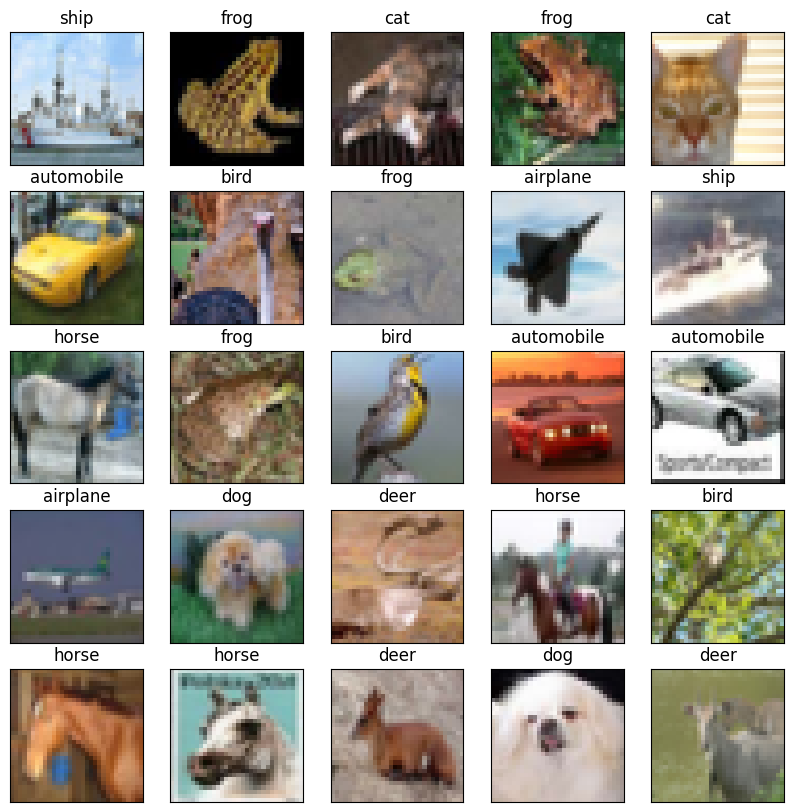

In [5]:
# select row x column random indices
rows, columns = 5, 5
sample = np.random.randint(0, 10000, rows * columns)
# get images/labels at random indicies
preview_images = images[sample]
preview_labels = [labels[0][i] for i in sample]
# 10 x 10 grid figure
fig=plt.figure(figsize=(10, 10))
# display 25 random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(preview_images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(label_names[preview_labels[i-1]])
plt.show()

###CNN

### The first block of code is building the convolutional base for the model.

 So essentially, the CNN model has two parts. One is the convolutional base part in which we try to reduce the number of nodes/parameters whihc will be fed into the neural network. Then the second part is actually building the neural network which predicts the class of the image based on the features.

In [6]:
#hyperparameter tuning for the CNN.
def create_model(dropout_1=0.1, dropout_2=0.3, passed_optimizer='adam'):
  cnn_model = models.Sequential()
  cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  cnn_model.add(layers.AveragePooling2D((2, 2)))
  cnn_model.add(layers.Dropout(dropout_1))
  cnn_model.add(layers.Conv2D(96, (3, 3), activation='relu'))
  cnn_model.add(layers.AveragePooling2D((2, 2)))
  cnn_model.add(layers.BatchNormalization())
  cnn_model.add(layers.Conv2D(96, (3, 3), activation='relu'))
  cnn_model.add(layers.AveragePooling2D((2, 2)))
  cnn_model.add(layers.Dropout(dropout_2))
  cnn_model.add(layers.BatchNormalization())
  cnn_model.add(layers.Flatten())
  cnn_model.add(layers.Dense(128, activation='relu'))
  cnn_model.add(layers.Dense(10, activation='softmax'))
  cnn_model.compile(optimizer=passed_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return cnn_model


In [7]:
def model_report(model):
  labels_predicted = base_model.predict(test_images_indexed / 255.0)
  max_label = [label_names[np.argmax(label)] for label in labels_predicted]

  # visualize these random images
  fig=plt.figure(figsize=(10, 10))
  for i in range(0, columns*rows):
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(test_images_indexed[i])
      plt.xticks([])
      plt.yticks([])
      plt.title("{}"
            .format(max_label[i]))
  plt.show()
  base_test_loss, base_test_accuracy = base_model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))
  #index_of_possible_labels = []
  #for i in range(num_cases_per_batch):
  #  index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
  #  index_of_possible_labels.append(index_max)
  #print('The accuracy is:- ', base_test_accuracy * 100, '%')
  #matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
  #sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names,cbar=False, square=True)
  #print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

In [8]:
callback_cnn = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, start_from_epoch=10, patience=2)
base_model = create_model()
# base_model.summary()
base_trained_model = base_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=20, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)), callbacks=[callback_cnn])

Epoch 1/20
1563/1563 [==============================] - 39s 8ms/step - loss: 1.5160 - accuracy: 0.4567 - val_loss: 1.2537 - val_accuracy: 0.5527
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1553 - accuracy: 0.5867 - val_loss: 0.9971 - val_accuracy: 0.6440
Epoch 3/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0066 - accuracy: 0.6456 - val_loss: 1.0477 - val_accuracy: 0.6405
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9133 - accuracy: 0.6782 - val_loss: 1.0169 - val_accuracy: 0.6547
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8506 - accuracy: 0.7024 - val_loss: 0.8118 - val_accuracy: 0.7139
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8031 - accuracy: 0.7163 - val_loss: 0.7895 - val_accuracy: 0.7305
Epoch 7/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7562 - accuracy: 0.7359 - val_loss: 0.7951 - val_accu

In [9]:
model_1 = KerasClassifier(model=create_model, verbose=0)
parameters = {
     'model__dropout_1': [0.1, 0.2],
     'model__dropout_2': [0.3, 0.4],
     'model__passed_optimizer': ['adam', 'adadelta'],
}
grid = GridSearchCV(estimator=model_1, param_grid=parameters, cv=2, scoring='accuracy', verbose=3)
grid_results = grid.fit(np.array(training_dataset / 255.0), np.array(training_labels), validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adam;, score=0.448 total time=  15.5s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adam;, score=0.488 total time=  12.2s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adadelta;, score=0.104 total time=  12.8s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adadelta;, score=0.140 total time=  15.4s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adam;, score=0.451 total time=  14.6s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adam;, score=0.475 total time=  15.5s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adadelta;, score=0.130 total time=  11.9s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adadelta;, sco

In [16]:
print(grid_results.best_estimator_)
print(grid_results.best_params_)
dp_1, dp_2, best_optimizer= grid_results.best_params_['model__dropout_1'], grid_results.best_params_['model__dropout_2'], grid_results.best_params_['model__passed_optimizer']
print(dp_1, dp_2)
if dp_1 != 0.1 or dp_2 != 0.3 or best_optimizer !='adam':
  best_model = create_model(dp_1, dp_2, passed_optimizer=best_optimizer)
  best_model.summary()
  best_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=20, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)), callbacks=[callback_cnn])
else:
  best_model = base_trained_model

KerasClassifier(
	model=<function create_model at 0x7dcad6e4a8c0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	model__dropout_1=0.1
	model__dropout_2=0.3
	model__passed_optimizer=adam
	class_weight=None
)
{'model__dropout_1': 0.1, 'model__dropout_2': 0.3, 'model__passed_optimizer': 'adam'}
0.1 0.3


Text(0.5, 1.0, 'Epochs vs Accuracy plot for CNN model')

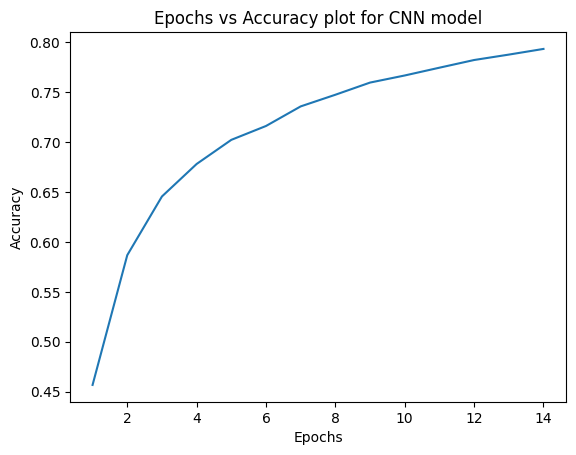

In [11]:
epochs_list_cnn = np.arange(1, len(np.asarray(best_model.history['accuracy']))+1)
plt.plot(epochs_list_cnn, np.asarray(best_model.history['accuracy']))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy plot for CNN model')

In [22]:
#model_report(best_model)
best_model.model.save_weights('cnn.keras')

### Naive Bayes Classifier model

In [45]:
nb = GaussianNB()
image_num, image_height, image_width, scale = training_dataset.shape
nb.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))

GaussianNB()

The accuracy of the Naive Bayes Classifier for Gaussian pdf is:-  29.759999999999998 %
              precision    recall  f1-score   support

           0       0.49      0.27      0.35      1817
           1       0.17      0.41      0.24       405
           2       0.08      0.19      0.12       443
           3       0.08      0.25      0.12       305
           4       0.42      0.24      0.30      1737
           5       0.26      0.31      0.29       840
           6       0.47      0.25      0.33      1846
           7       0.13      0.42      0.20       310
           8       0.47      0.39      0.42      1219
           9       0.41      0.38      0.39      1078

    accuracy                           0.30     10000
   macro avg       0.30      0.31      0.28     10000
weighted avg       0.39      0.30      0.32     10000



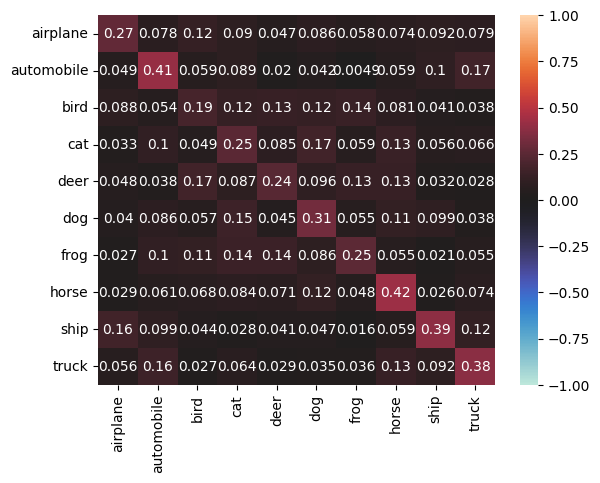

In [47]:
test_num, test_image_height, test_image_width, scale_test = test_images_indexed.shape
predicted_labels = nb.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))
print('The accuracy of the Naive Bayes Classifier for Gaussian pdf is:- ', accuracy_score(predicted_labels, test_labels_indexed) * 100, '%')
matrix_nb = confusion_matrix(np.array(predicted_labels), test_labels_indexed, normalize='true')
sb.heatmap(matrix_nb, vmin=-1, vmax=1, center=0, xticklabels=label_names, yticklabels=label_names, annot=True)
print(classification_report(predicted_labels, np.array(test_labels_indexed)))

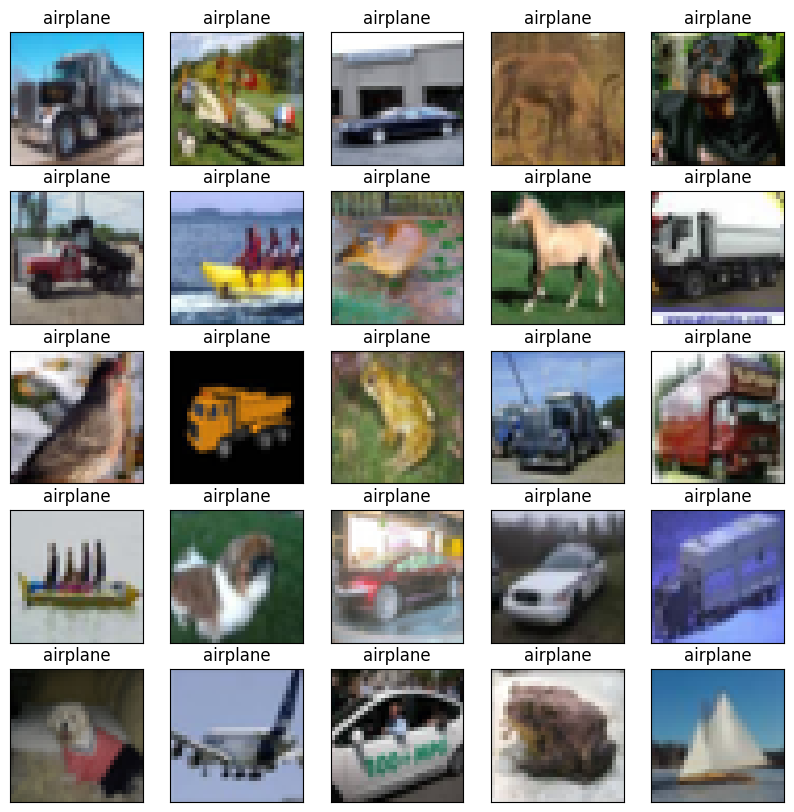

In [48]:
max_label = []
max_label = [label_names[np.argmax(label)] for label in predicted_labels]
# visualize these random images
fig=plt.figure(figsize=(10, 10))
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test_images_indexed[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(max_label[i]))
plt.show()

### KNN model

In [50]:
##defines the knn model based on the neighbors and how to weigh each point in our neighborhood.
knn_model = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))
knn_prediction = knn_model.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))

In [53]:
knn_accuracy = accuracy_score(np.array(test_labels_indexed), knn_prediction)
print('The accuracy for the KNN model is:- ', knn_accuracy * 100, '%\n')

The accuracy for the KNN model is:-  35.39 %



              precision    recall  f1-score   support

           0       0.48      0.42      0.45      1144
           1       0.22      0.65      0.33       336
           2       0.38      0.24      0.30      1584
           3       0.24      0.29      0.26       823
           4       0.46      0.25      0.32      1834
           5       0.29      0.36      0.32       798
           6       0.35      0.33      0.34      1075
           7       0.29      0.56      0.39       526
           8       0.62      0.40      0.49      1552
           9       0.20      0.61      0.30       328

    accuracy                           0.35     10000
   macro avg       0.35      0.41      0.35     10000
weighted avg       0.41      0.35      0.36     10000



<Axes: >

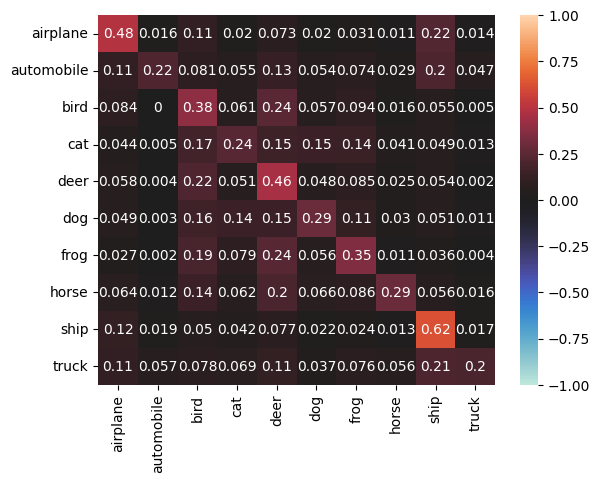

In [54]:
print(classification_report(knn_prediction, np.array(test_labels_indexed)))
knn_matrix = confusion_matrix(np.array(test_labels_indexed), knn_prediction, normalize='true')
sb.heatmap(knn_matrix, vmin=-1, vmax=1, center=0, annot=True, xticklabels=label_names, yticklabels=label_names)

In [56]:
parameters = [{
    'n_neighbors': [2, 3, 4],
    'weights': ['uniform', 'distance']
}]
knn_model_optimized = KNeighborsClassifier()
grid_model = GridSearchCV(estimator=knn_model_optimized, param_grid=parameters, cv=2, return_train_score=True, verbose=3)
grid_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END n_neighbors=2, weights=uniform;, score=(train=0.627, test=0.291) total time= 1.7min
[CV 2/2] END n_neighbors=2, weights=uniform;, score=(train=0.613, test=0.284) total time= 1.6min
[CV 1/2] END n_neighbors=2, weights=distance;, score=(train=1.000, test=0.322) total time= 1.6min
[CV 2/2] END n_neighbors=2, weights=distance;, score=(train=1.000, test=0.317) total time= 1.6min
[CV 1/2] END n_neighbors=3, weights=uniform;, score=(train=0.558, test=0.310) total time= 1.6min
[CV 2/2] END n_neighbors=3, weights=uniform;, score=(train=0.561, test=0.308) total time= 1.6min
[CV 1/2] END n_neighbors=3, weights=distance;, score=(train=1.000, test=0.328) total time= 1.6min
[CV 2/2] END n_neighbors=3, weights=distance;, score=(train=1.000, test=0.325) total time= 1.5min
[CV 1/2] END n_neighbors=4, weights=uniform;, score=(train=0.517, test=0.316) total time= 1.6min
[CV 2/2] END n_neighbors=4, weights=uniform;, score=(train=0.52

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, verbose=3)

In [57]:
print(grid_model.best_estimator_)
best_neighbors, best_weights_attribute = grid_model.best_params_['n_neighbors'], grid_model.best_params_['weights']
print(best_neighbors, best_weights_attribute)

KNeighborsClassifier(n_neighbors=4, weights='distance')
4 distance


In [58]:
best_knn_model = KNeighborsClassifier(n_neighbors=best_neighbors, weights=best_weights_attribute)
best_knn_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))
knn_prediction_optimized = best_knn_model.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))

In [59]:
best_knn_accuracy = accuracy_score(np.array(test_labels_indexed), knn_prediction_optimized)
print('The accuracy for the KNN model after hyperparameter tuning is:- ', best_knn_accuracy * 100, '%\n')

The accuracy for the KNN model after hyperparameter tuning is:-  35.42 %



              precision    recall  f1-score   support

           0       0.49      0.44      0.47      1110
           1       0.20      0.70      0.32       291
           2       0.39      0.24      0.30      1591
           3       0.21      0.30      0.25       717
           4       0.50      0.24      0.33      2078
           5       0.28      0.39      0.32       706
           6       0.33      0.33      0.33      1001
           7       0.27      0.59      0.37       452
           8       0.69      0.39      0.50      1783
           9       0.19      0.69      0.29       271

    accuracy                           0.35     10000
   macro avg       0.35      0.43      0.35     10000
weighted avg       0.43      0.35      0.36     10000



<Axes: >

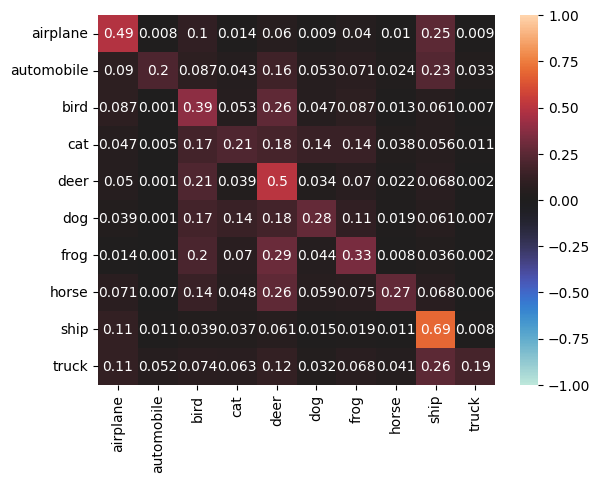

In [60]:
print(classification_report(knn_prediction_optimized, np.array(test_labels_indexed)))
knn_matrix = confusion_matrix(np.array(test_labels_indexed), knn_prediction_optimized, normalize='true')
sb.heatmap(knn_matrix, vmin=-1, vmax=1, center=0, annot=True, xticklabels=label_names, yticklabels=label_names)

RNN-CNN model

In [ ]:
def rnn_cnn(repeated_vector_num = 1, lstm_value=256):
  rnn_cnn_model = models.Sequential()
  rnn_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  rnn_cnn_model.add(layers.AveragePooling2D((2, 2)))
  rnn_cnn_model.add(layers.Dropout(dropout_1))
  rnn_cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  rnn_cnn_model.add(layers.AveragePooling2D((2, 2)))
  rnn_cnn_model.add(layers.BatchNormalization())
  rnn_cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  rnn_cnn_model.add(layers.Dropout(dropout_2))
  rnn_cnn_model.add(layers.AveragePooling2D((2, 2)))
  rnn_cnn_model.add(layers.BatchNormalization())
  rnn_cnn_model.add(layers.Flatten())
  rnn_cnn_model.add((layers.Dense(128, activation='relu')))
  rnn_cnn_model.add(tf.keras.layers.RepeatVector(repeated_vector_num))
  rnn_cnn_model.add(tf.keras.layers.LSTM(units=lstm_value))
  rnn_cnn_model.add(layers.Dense(10, activation='sigmoid'))
  rnn_cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
  return rnn_cnn_model


In [ ]:
callback_r_cnn = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, start_from_epoch=10, patience=2)
### label based-resampling for the image
rnn_cnn_model = rnn_cnn()
rnn_cnn_model.summary()
trained_model = rnn_cnn_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=20, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)), callbacks=callback_r_cnn)

In [ ]:
model_report(rnn_cnn_model)

In [ ]:
rcmodel = KerasClassifier(model=rnn_cnn, verbose=0)
parameters= {
    'model__repeated_vector_num': [1, 8],
    'model__lstm_value': [128, 256],
}
rcgrid = GridSearchCV(estimator=rcmodel, param_grid=parameters, cv=2, scoring='accuracy', verbose=3)

In [ ]:
rc_grid_results = rcgrid.fit(np.array(training_dataset / 255.0), np.array(training_labels), validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))
best_lstm_value, best_repeated_vector_num = rc_grid_results.best_params_['model__lstm_value'], rc_grid_results.best_params_['model__repeated_vector_num']
print(best_lstm_value, best_repeated_vector_num)

In [ ]:
if best_repeated_vector_num != 1 or best_lstm_value != 256:
  best_rnn_cnn_model = rnn_cnn(repeated_vector_num=best_repeated_vector_num,
                             lstm_value=best_lstm_value)
  trained_model = best_rnn_cnn_model.fit(np.array(training_dataset / 255.0),
                                  np.array(training_labels), epochs=20, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)), callbacks=callback_r_cnn)
else:
  best_rnn_cnn_model = rnn_cnn_model

In [ ]:
labels_predicted = best_rnn_cnn_model.predict(test_images_indexed / 255.0)
max_label = [label_names[np.argmax(label)] for label in labels_predicted]
index_of_possible_labels = []
for i in range(num_cases_per_batch):
  index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
  index_of_possible_labels.append(index_max)
test_loss_r_cnn, test_accuracy_r_cnn = best_rnn_cnn_model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))
print('The accuracy for the RNN-CNN model on test data is:- ', test_accuracy_r_cnn * 100, '%')
matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names, cbar=False, square=True)
print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

In [ ]:
best_rnn_cnn_model.model.save_weights('cnn.keras').save_weights('./rnn_cnn.keras')